# Example: Birth Rate (Hoff, 2009)

This notebook is implement the Example: Birth Rate (Hoff, 2009) in Lecture 3 note

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, nbinom
from scipy.integrate import quad

# Note: Matplotlib is used with default styles/colors.
# Do not set explicit colors unless desired.

## Number of Children in two groups

In [2]:
# Number of women and total number of children in two groups (with and without college degree)
n_1, sum_y_1 = 111, 217  # Group 1 (without college degree)
n_2, sum_y_2 = 44, 66    # Group 2 (with college degree)

# Prior parameters for the Gamma distribution (conjugate prior for Poisson)
alpha, beta = 2, 1  # Gamma(shape=alpha, rate=beta); SciPy uses scale=1/beta

## Posterior distribution of **average** number of children




In [3]:
def plot_poisson_mean_density(n_1, sum_y_1, n_2, sum_y_2, alpha, beta,
                              xlim=(0, 6), ylim=None, save_pdf_path=None):
    """
    Plots the prior and posterior probability densities for the Poisson mean (theta).

    Args:
        n_1 (int): Number of observations in group 1.
        sum_y_1 (int): Sum of observations in group 1.
        n_2 (int): Number of observations in group 2.
        sum_y_2 (int): Sum of observations in group 2.
        alpha (float): Shape parameter of the prior Gamma distribution.
        beta (float): Rate parameter of the prior Gamma distribution.
        xlim (tuple): x-axis limits for the plot.
        ylim (tuple): y-axis limits for the plot.
        save_pdf_path (str): Path to save the plot as a PDF file.
    """
    theta = np.arange(xlim[0], xlim[1] + 1e-9, 0.001)

    # Calculate the prior and posterior densities using the Gamma distribution
    prior_density = gamma.pdf(theta, a=alpha, scale=1.0/beta)
    post1_density = gamma.pdf(theta, a=alpha + sum_y_1, scale=1.0/(beta + n_1)) # Posterior for group 1
    post2_density = gamma.pdf(theta, a=alpha + sum_y_2, scale=1.0/(beta + n_2)) # Posterior for group 2

    # Set y-axis limits if not provided
    if ylim is None:
        ylim = (0, max(prior_density.max(), post1_density.max(), post2_density.max()))

    # Plot the densities
    plt.figure()
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel(r"$\theta$")
    plt.ylabel("Density")
    plt.title("Posterior Distribution")
    plt.plot(theta, prior_density, linewidth=2, label=r"$\mathrm{Ga}(\alpha,\ \beta)$")
    plt.plot(theta, post1_density, linewidth=2, label=r"$\mathrm{Ga}(\alpha+\sum y_{1j},\ \beta+n_1)$")
    plt.plot(theta, post2_density, linewidth=2, label=r"$\mathrm{Ga}(\alpha+\sum y_{2j},\ \beta+n_2)$")
    plt.legend(loc="upper right")

    # Save the plot if a path is provided
    if save_pdf_path is not None:
        plt.savefig(save_pdf_path, format="pdf", bbox_inches="tight")

    plt.show()

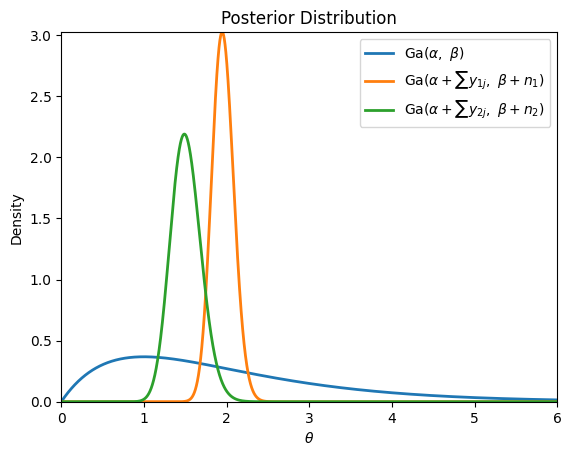

In [4]:
# Plot the posterior densities for the Poisson means
plot_poisson_mean_density(n_1, sum_y_1, n_2, sum_y_2, alpha, beta, xlim=(0, 6), save_pdf_path=None)

## Posterior Preditive distribution of number of children

In [5]:
def plot_poisson_predictive_density(n_1, sum_y_1, n_2, sum_y_2, alpha, beta,
                                    xlim=(0, 12), ylim=None, save_pdf_path=None):
    """
    Plots the posterior predictive probability mass functions for the number of children.

    Args:
        n_1 (int): Number of observations in group 1.
        sum_y_1 (int): Sum of observations in group 1.
        n_2 (int): Number of observations in group 2.
        sum_y_2 (int): Sum of observations in group 2.
        alpha (float): Shape parameter of the prior Gamma distribution.
        beta (float): Rate parameter of the prior Gamma distribution.
        xlim (tuple): x-axis limits for the plot.
        ylim (tuple): y-axis limits for the plot.
        save_pdf_path (str): Path to save the plot as a PDF file.
    """
    # Range of possible number of children
    tilde_y = np.arange(xlim[0], xlim[1] + 1e-9, 1, dtype=int)

    # Parameters for the Negative Binomial predictive distribution
    p1 = (beta + n_1) / (beta + n_1 + 1.0)
    p2 = (beta + n_2) / (beta + n_2 + 1.0)
    size1 = alpha + sum_y_1
    size2 = alpha + sum_y_2

    # Calculate the predictive probabilities (PMF) using the Negative Binomial distribution
    pred1 = nbinom.pmf(tilde_y, n=size1, p=p1) # Predictive distribution for group 1
    pred2 = nbinom.pmf(tilde_y, n=size2, p=p2) # Predictive distribution for group 2

    # Set y-axis limits if not provided
    if ylim is None:
        ylim = (0, max(pred1.max(), pred2.max()))

    # Plot the predictive distributions as bar plots
    plt.figure()
    plt.xlabel(r"$\tilde{y}$")
    plt.ylabel("Probability")
    plt.title("Predictive Distribution")
    width = 0.4
    x = np.arange(len(tilde_y))
    plt.bar(x - width/2, pred1, width=width, label=r"$\mathrm{NegBin}(\alpha+\sum y_{1j},\ \beta+n_1)$")
    plt.bar(x + width/2, pred2, width=width, label=r"$\mathrm{NegBin}(\alpha+\sum y_{2j},\ \beta+n_2)$")
    plt.xticks(x, tilde_y)
    plt.ylim(*ylim)
    plt.legend(loc="upper right")

    # Save the plot if a path is provided
    if save_pdf_path is not None:
        plt.savefig(save_pdf_path, format="pdf", bbox_inches="tight")

    plt.show()

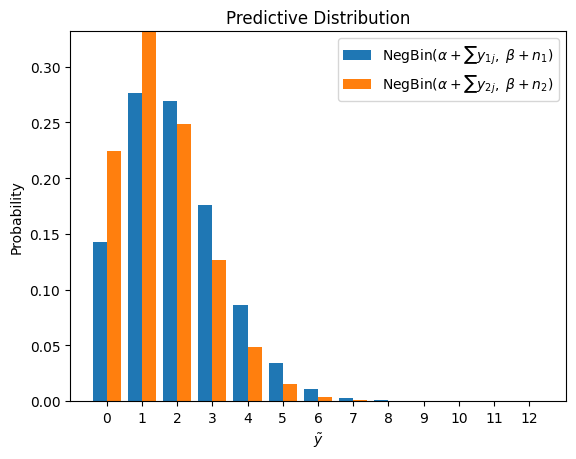

In [6]:
# Plot the posterior predictive distributions
plot_poisson_predictive_density(n_1, sum_y_1, n_2, sum_y_2, alpha, beta, save_pdf_path=None)

##To answer the following questions, what should we compute and how to do it

### How likely the average number of children for women without college degree is large than the average number of children for women with college degree given the data?

In [7]:
def posterior_prob_theta1_gt_theta2(n_1, sum_y_1, n_2, sum_y_2, alpha, beta):
    """
    Calculates the posterior probability that the average number of children for group 1 (without college degree)
    is greater than the average number of children for group 2 (with college degree).

    This is calculated by integrating the product of the CDF of the posterior for theta2 and the PDF of the
    posterior for theta1 over the range of theta values.

    Args:
        n_1 (int): Number of observations in group 1.
        sum_y_1 (int): Sum of observations in group 1.
        n_2 (int): Number of observations in group 2.
        sum_y_2 (int): Sum of observations in group 2.
        alpha (float): Shape parameter of the prior Gamma distribution.
        beta (float): Rate parameter of the prior Gamma distribution.

    Returns:
        float: The posterior probability P(theta_1 > theta_2).
    """
    # Posterior parameters for the Gamma distributions
    a1, b1 = alpha + sum_y_1, beta + n_1
    a2, b2 = alpha + sum_y_2, beta + n_2

    # Define the integrand: CDF of theta2 * PDF of theta1
    def integrand(x):
        return gamma.cdf(x, a=a2, scale=1.0/b2) * gamma.pdf(x, a=a1, scale=1.0/b1)

    # Perform the numerical integration from 0 to infinity
    val, _ = quad(integrand, 0, np.inf, limit=200)
    return val

In [8]:
# Calculate and print the posterior probability that theta_1 > theta_2
post_prob = posterior_prob_theta1_gt_theta2(n_1, sum_y_1, n_2, sum_y_2, alpha, beta)
print(f"P(theta_1 > theta_2) ≈ {post_prob:.6f}")

P(theta_1 > theta_2) ≈ 0.972560


How likely the number of children of a woman with college degree is strictly larger than (exactly the same as) that of a woman without college degree given the data?


In [9]:
def predictive_probs(n_1, sum_y_1, n_2, sum_y_2, alpha, beta, max_k_gt=1000, max_k_eq=1000):
    """
    Calculates the predictive probabilities for the number of children:
    1. P(ỹ_1 > ỹ_2): Probability that a new observation from group 1 is strictly greater than a new observation from group 2.
    2. P(ỹ_1 = ỹ_2): Probability that a new observation from group 1 is equal to a new observation from group 2.

    These probabilities are calculated by summing over the product of the predictive PMFs (Negative Binomial).

    Args:
        n_1 (int): Number of observations in group 1.
        sum_y_1 (int): Sum of observations in group 1.
        n_2 (int): Number of observations in group 2.
        sum_y_2 (int): Sum of observations in group 2.
        alpha (float): Shape parameter of the prior Gamma distribution.
        beta (float): Rate parameter of the prior Gamma distribution.
        max_k_gt (int): Maximum value of k to consider for P(ỹ_1 > ỹ_2) summation.
        max_k_eq (int): Maximum value of k to consider for P(ỹ_1 = ỹ_2) summation.

    Returns:
        tuple: A tuple containing the calculated probabilities (prob_gt, prob_eq).
    """
    # Parameters for the Negative Binomial predictive distribution
    size1 = alpha + sum_y_1
    size2 = alpha + sum_y_2
    p1 = (beta + n_1) / (beta + n_1 + 1.0)
    p2 = (beta + n_2) / (beta + n_2 + 1.0)

    # Calculate P(ỹ_1 > ỹ_2) = Sum over k from 1 to infinity of P(ỹ_1 = k) * P(ỹ_2 < k)
    # P(ỹ_2 < k) is the CDF of the negative binomial distribution for ỹ_2 evaluated at k-1
    ks_gt = np.arange(1, max_k_gt + 1)
    cdfs2 = nbinom.cdf(ks_gt - 1, n=size2, p=p2)
    pmf1 = nbinom.pmf(ks_gt, n=size1, p=p1)
    prob_gt = np.sum(cdfs2 * pmf1)

    # Calculate P(ỹ_1 = ỹ_2) = Sum over k from 0 to infinity of P(ỹ_1 = k) * P(ỹ_2 = k)
    ks_eq = np.arange(0, max_k_eq + 1)
    pmf1_eq = nbinom.pmf(ks_eq, n=size1, p=p1)
    pmf2_eq = nbinom.pmf(ks_eq, n=size2, p=p2)
    prob_eq = np.sum(pmf1_eq * pmf2_eq)

    return prob_gt, prob_eq

In [10]:
# Calculate and print the predictive probabilities
pred_prob_gt, pred_prob_eq = predictive_probs(n_1, sum_y_1, n_2, sum_y_2, alpha, beta)
print(f"P(ỹ_1 > ỹ_2) ≈ {pred_prob_gt:.6f}")
print(f"P(ỹ_1 = ỹ_2) ≈ {pred_prob_eq:.6f}")

P(ỹ_1 > ỹ_2) ≈ 0.482089
P(ỹ_1 = ỹ_2) ≈ 0.217675
